# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

Invalid requirement: './python'
Traceback (most recent call last):
  File "C:\Users\mhei\AppData\Local\conda\conda\envs\drlnd2\lib\site-packages\pip\_vendor\packaging\requirements.py", line 93, in __init__
    req = REQUIREMENT.parseString(requirement_string)
  File "C:\Users\mhei\AppData\Local\conda\conda\envs\drlnd2\lib\site-packages\pip\_vendor\pyparsing.py", line 1654, in parseString
    raise exc
  File "C:\Users\mhei\AppData\Local\conda\conda\envs\drlnd2\lib\site-packages\pip\_vendor\pyparsing.py", line 1644, in parseString
    loc, tokens = self._parse( instring, 0 )
  File "C:\Users\mhei\AppData\Local\conda\conda\envs\drlnd2\lib\site-packages\pip\_vendor\pyparsing.py", line 1402, in _parseNoCache
    loc,tokens = self.parseImpl( instring, preloc, doActions )
  File "C:\Users\mhei\AppData\Local\conda\conda\envs\drlnd2\lib\site-packages\pip\_vendor\pyparsing.py", line 3417, in parseImpl
    loc, exprtokens = e._parse( instring, loc, doActions )
  File "C:\Users\mhei\AppData\Local

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
# from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='data/Reacher_Windows_x86_64/Reacher.exe')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
time = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    time += 1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print(time)

Total score (averaged over agents) this episode: 0.19999999552965164
1001


### Learning to act in the reacher environment with DDPG

We will use the [DDPG algorithm](https://arxiv.org/abs/1509.02971) to attempt to learn to act in the environment described in the `README.md`. Below we define the building blocks for this algorithm.

In [5]:
from collections import namedtuple, deque
import random
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

We use essentially the same `ReplayBuffer` class as in the Navigation project, except this time we want to be able to retrieve and set the state of the buffer.

In [6]:
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory.

        Params
        ======
            batch_size (int): size of the training batch to sample
        """
        experiences = random.sample(self.memory, k=batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    def state_dict(self):
        return {
            'memory': self.memory
        }
    
    def load_state_dict(self, state_dict):
        self.memory = state_dict['memory']
        

Define a noise process based on the [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [7]:
class OrnsteinUhlenbeckNoise():
    """Ornstein-Uhlenbeck process."""
    
    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()
    
    def reset(self):
        self.state = np.copy(self.mu)
    
    def sample(self):
        dmean = self.state - self.mu
        dx = -self.theta * dmean + self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state
    
    def state_dict(self):
        return {
            'size': self.size,
            'mu': self.mu,
            'theta': self.theta,
            'sigma': self.sigma,
            'state': self.state
        }
    
    def load_state_dict(self, state_dict):
        self.size = state_dict['size']
        self.mu = state_dict['mu']
        self.theta = state_dict['theta']
        self.sigma = state_dict['sigma']
        self.state = state_dict['state']

Define a utility function for performing soft updates of network parameters

In [8]:
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    target parameters = tau * local parameters + (1 - tau) * target parameters
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0 - tau) * target_param.data)

Define a suitable neural network to act as the actor network in DDPG in this environment

In [9]:
class ActorNetwork3Layer(nn.Module):
    """Actor Model for DDPG"""

    def __init__(self, state_size, action_size, seed, nh1=64, nh2=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(ActorNetwork3Layer, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.FC1 = nn.Linear(state_size, nh1)
        self.FC2 = nn.Linear(nh1, nh2)
        self.Output = nn.Linear(nh2, action_size)

    def forward(self, state):
        return F.tanh(self.Output(F.leaky_relu(self.FC2(F.leaky_relu(self.FC1(state))))))

Define a suitable neural network to act as the criticnetwork in DDPG in this environment

In [10]:
class CriticNetwork3Layer(nn.Module):
    """Critic Model for DDPG"""

    def __init__(self, state_size, action_size, seed, nh1=64, nh2=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(CriticNetwork3Layer, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.FC1 = nn.Linear(state_size + action_size, nh1)
        self.FC2 = nn.Linear(nh1, nh2)
        self.Output = nn.Linear(nh2, 1)

    def forward(self, state, action):
        """Build a network that maps state -> action values."""
        return self.Output(F.leaky_relu(self.FC2(F.leaky_relu(self.FC1(torch.cat((state, action), dim=1))))))

Define an agent that takes care of most of the work in the DDPG algorithm.

In [19]:
# Depending on whether Cuda is available, place tensor computations on the GPU or CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def mutate_param(param, grow_factor=2.):
    choice = np.random.randint(-1, 1)
    if choice == -1:
        return param / grow_factor
    if choice == 0:
        return param
    return param * grow_factor
    

class DdpgAgent():
    """Interacts with the environment and does most of the work of the DDPG algorightm,
    manipulating the relevant actor and critic networks and their target copies.
    """
    def __init__(self,
                 buffer_size=5e4,
                 steps_between_updates=1,
                 batch_size=64,
                 actor_lr=3e-4,
                 critic_lr=3e-4,
                 tau=1e-4,
                 gamma=0.99,
                 seed=66,
                 action_space_limit=1,
                 state_size=33,
                 action_size=4):
        """Initialize the DdpgAgent object"""
        self.actor_network_local = ActorNetwork3Layer(state_size, action_size, seed).to(device)
        self.critic_network_local = CriticNetwork3Layer(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_network_local.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic_network_local.parameters(), lr=critic_lr)
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.actor_network_target = ActorNetwork3Layer(state_size, action_size, seed).to(device)
        self.critic_network_target = CriticNetwork3Layer(state_size, action_size, seed).to(device)
        self.noise = OrnsteinUhlenbeckNoise(action_size)
        self.experience = ReplayBuffer(int(buffer_size), seed)
        self.steps_between_updates = steps_between_updates
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma
        self.t_step = 0
        self.action_space_limit = action_space_limit
    
    def act(self, state):
        """Select action based on state"""
        with torch.no_grad():
            state_tensor = torch.from_numpy(state).float().to(device)
            self.actor_network_local.eval()
            action = self.actor_network_local(state_tensor).cpu().data.numpy()
            self.actor_network_local.train()
            action += self.noise.sample()
            return np.clip(action, -self.action_space_limit, self.action_space_limit)
    
    def step(self, state, action, reward, next_state, done):
        """Record experience and learn based on observed step"""
        self.experience.add(state, action, reward, next_state, done)
        self.t_step += 1
        if self.t_step % self.steps_between_updates == 0:
            self.t_step = 0
            self.learn()
    
    def learn(self):
        if len(self.experience) < self.batch_size:
            return
        # sample a batch of experience
        experiences = self.experience.sample(self.batch_size)
        states, actions, rewards, next_states, dones = experiences
        # update critic
        # calculate targets
        with torch.no_grad():
            next_actions = self.actor_network_target(next_states)
            Q_targets_next = self.critic_network_target(next_states, next_actions)
            Q_targets = Q_targets_next + self.gamma * rewards
        Q_predicted = self.critic_network_local(states, actions)
        critic_loss = F.mse_loss(Q_predicted, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # update actor
        predicted_actions = self.actor_network_local(states)
        actor_loss = -self.critic_network_local(states, predicted_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # soft update targets towards locals
        self.soft_update()
    
    def soft_update(self):
        soft_update(self.actor_network_local, self.actor_network_target, self.tau)
        soft_update(self.critic_network_local, self.critic_network_target, self.tau)
    
    def forward_state_dict(self):
        return {
            'actor': self.actor_network_local.state_dict(),
            'critic': self.critic_network_local.state_dict(),
            'actor_target': self.actor_network_target.state_dict(),
            'critic_target': self.critic_network_target.state_dict(),
            'noise': self.noise.state_dict()
        }
    
    def load_forward_state_dict(self, state_dict):
        self.actor_network_local.load_state_dict(state_dict['actor'])
        self.critic_network_local.load_state_dict(state_dict['critic'])
        self.actor_network_target.load_state_dict(state_dict['actor_target'])
        self.critic_network_target.load_state_dict(state_dict['critic_target'])
        self.noise.load_state_dict(state_dict['noise'])
    
    def learning_state_dict(self):
        return {
            'actor_optim_state': self.actor_optimizer.state_dict(),
            'critic_optim_state': self.critic_optimizer.state_dict(),
            'replay_buffer': self.experience.state_dict()
        }
    
    def load_learning_state_dict(self, state_dict):
        self.actor_optimizer.load_state_dict(state_dict['actor_optim_state'])
        self.critic_optimizer.load_state_dict(state_dict['critic_optim_state'])
        self.experience.load_state_dict(state_dict['replay_buffer'])
    
    def state_dict(self):
        return {
            'forward': self.forward_state_dict(),
            'learning': self.learning_state_dict()
        }
    
    def load_state_dict(self, state_dict):
        self.load_forward_state_dict(state_dict['forward'])
        self.load_learning_state_dict(state_dict['learning'])
    
    def hyperparameter_dict(self):
        return {
            'actor_lr': self.actor_lr,
            'critic_lr': self.critic_lr,
            'gamma': self.gamma,
            'tau': self.tau
        }
    
    def load_hyperparameter_dict(self, hyperparameter_dict):
        for p in self.actor_optimizer.param_groups:
            p['lr'] = hyperparameter_dict['actor_lr']
        for p in self.critic_optimizer.param_groups:
            p['lr'] = hyperparameter_dict['critic_lr']
        self.gamma = hyperparameter_dict['gamma']
        self.tau = hyperparameter_dict['tau']
    
    def load_mutated_hyperparameter_dict(self, hyperparameter_dict):
        self.load_hyperparameter_dict({
            'actor_lr': mutate_param(hyperparameter_dict['actor_lr']),
            'critic_lr': mutate_param(hyperparameter_dict['critic_lr']),
            'gamma': 1 - mutate_param(1 - hyperparameter_dict['gamma']),
            'tau': mutate_param(hyperparameter_dict['tau']),
        })
    
    def full_save_dict(self, scores, agent_name):
        return {
            'agent_name': agent_name,
            'state': self.state_dict(),
            'hyperparameters': self.hyperparameter_dict(),
            'scores': scores
        }
    
    def load_full_save_dict(self, full_save_dict):
        self.load_state_dict(full_save_dict['state'])
        self.load_hyperparameter_dict(full_save_dict['hyperparameters'])


In [12]:
def ddpg(agent, env, brain_name,
         max_episode=1000, max_t=1100, previous_scores=None,
         solution_threshold=30, solution_episodes=100,
         checkpoint_episodes=100, agent_name='agent-0'):
    """Carry out learning based on the DDPG algorithm."""
    scores = previous_scores if previous_scores else []
    scores_window = deque(scores, maxlen=solution_episodes)
    for i_episode in range(len(scores) + 1, max_episode+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        score = 0
        for t in range(0, max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % checkpoint_episodes == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.full_save_dict(scores, agent_name),"{}_episode_{}.pth".format(agent_name, i_episode))
        if len(scores_window) >= solution_episodes and np.mean(scores_window)>=solution_threshold:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-solution_episodes, np.mean(scores_window)))
            torch.save(agent.full_state_dict(scores, agent_name),"{}_solved.pth".format(agent_name))
            break
    return scores


Let's try to find good hyperparameters and training results simultaenously with [population based training](https://arxiv.org/abs/1711.09846)

In [13]:
starting_hyperparams = [{
        'actor_lr': actor_lr,
        'critic_lr': critic_lr,
        'gamma': gamma,
        'tau': tau
    }
    for actor_lr in [1e-3, 3e-4]
    for critic_lr in [1e-3, 3e-4]
    for gamma in [0.95, 0.99]
    for tau in [3e-4, 1e-4]
]
starting_hyperparams

[{'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.0003, 'gamma': 0.

In [18]:
starting_agents = [
    DdpgAgent(actor_lr=p['actor_lr'],
              critic_lr=p['critic_lr'],
              tau=p['tau'],
              gamma=p['gamma'])
    for p in starting_hyperparams]

In [14]:
def population_based_training(agents, env, brain_name,
                              max_episode=20,
                              max_t=1100,
                              episodes_between_exploit=20,
                              p_threshold = 0.05,
                              existing_scores = None,
                              checkpoint_episodes = None):
    checkpoint_episodes = checkpoint_episodes if checkpoint_episodes else episodes_between_exploits
    agent_scores = existing_scores if existing_scores else [[] for a in agents]
    episode_i = len(agent_scores[0]) + 1
    while episode_i <= max_episode:
        episode_i += episodes_between_exploit
        for agent_i, agent in enumerate(agents):
            prev_t = len(agent_scores[agent_i])
            agent_scores[agent_i] = ddpg(
                agent, env, brain_name,
                max_episode=prev_t + episodes_between_exploit,
                previous_scores=agent_scores[agent_i],
                agent_name="agent_{}".format(agent_i),
                checkpoint_episodes=checkpoint_episodes
            )
            print("\r\nAgent: {}, mean return: {:.2f}".format(agent_i, np.mean(agent_scores[agent_i][-episodes_between_exploit:])))
        for target_i, target_agent in enumerate(agents):
            # uniformly select a candidate that is not the same as target
            candidate_i = np.random.randint(0, len(agents) - 1)
            if candidate_i >= target_i:
                candidate_i += 1
            candidate = agents[candidate_i]
            # exploit
            candidate_scores = agent_scores[candidate_i][-episodes_between_exploit:]
            target_scores = agent_scores[target_i][-episodes_between_exploit:]
            exploited = False
            if np.mean(candidate_scores) > np.mean(target_scores):
                statistic, p = stats.ttest_ind(candidate_scores, target_scores, equal_var=False)
                if p < p_threshold:
                    print("Overwriting agent {} with agent {}, p = {:.2f}".format(target_i, candidate_i, p))
                    agent_name = "agent_{}".format(target_i)
                    torch.save(target_agent.full_save_dict(agent_scores[target_i], agent_name),
                              "retire_{}_episode_{}.pth".format(agent_name, len(agent_scores[target_i])))
                    exploited = True
                    target_agent.load_state_dict(candidate.state_dict())
                else:
                    print("Agent {} performed worse than agent {} but it wasn't significant, p = {:.2f}".format(target_i, candidate_i, p))
            if exploited:
                # explore
                source_hyperparameters = candidate.hyperparameter_dict()
                target_agent.load_mutated_hyperparameter_dict(source_hyperparameters)
    return agent_scores


In [ ]:
scores = population_based_training(starting_agents, env, brain_name, max_episode=1000, episodes_between_exploit=20, checkpoint_episodes=20)

Episode 20	Average Score: 0.15

Agent: 0, mean return: 0.15
Episode 20	Average Score: 0.28

Agent: 1, mean return: 0.28
Episode 20	Average Score: 0.50

Agent: 2, mean return: 0.50
Episode 20	Average Score: 0.09

Agent: 3, mean return: 0.09
Episode 20	Average Score: 1.00

Agent: 4, mean return: 1.00
Episode 20	Average Score: 0.49

Agent: 5, mean return: 0.49
Episode 20	Average Score: 0.59

Agent: 6, mean return: 0.59
Episode 20	Average Score: 0.66

Agent: 7, mean return: 0.66
Episode 20	Average Score: 0.39

Agent: 8, mean return: 0.39
Episode 20	Average Score: 0.78

Agent: 9, mean return: 0.78
Episode 20	Average Score: 0.03

Agent: 10, mean return: 0.03
Episode 20	Average Score: 0.56

Agent: 11, mean return: 0.56
Episode 20	Average Score: 0.79

Agent: 12, mean return: 0.79
Episode 20	Average Score: 0.59

Agent: 13, mean return: 0.59
Episode 20	Average Score: 0.67

Agent: 14, mean return: 0.67
Episode 20	Average Score: 0.29

Agent: 15, mean return: 0.29
Overwriting agent 0 with agent 13,

In [15]:
saved_values = [torch.load('agent_{}_episode_60.pth'.format(i)) for i in range(0,16)]

In [20]:
agents = [DdpgAgent() for dict in saved_values]
for i, saved_dict in enumerate(saved_values):
    agents[i].load_full_save_dict(saved_dict)

In [21]:
scores = [saved_dict['scores'] for saved_dict in saved_values]

In [22]:
scores = population_based_training(agents, env, brain_name, existing_scores=scores, max_episode=400, episodes_between_exploit=20, checkpoint_episodes=20)

Episode 80	Average Score: 0.58

Agent: 0, mean return: 1.05
Episode 80	Average Score: 0.32

Agent: 1, mean return: 0.53
Episode 80	Average Score: 0.47

Agent: 2, mean return: 0.77
Episode 80	Average Score: 0.33

Agent: 3, mean return: 0.45
Episode 80	Average Score: 1.02

Agent: 4, mean return: 1.10
Episode 80	Average Score: 0.31

Agent: 5, mean return: 0.17
Episode 80	Average Score: 0.74

Agent: 6, mean return: 0.41
Episode 80	Average Score: 0.36

Agent: 7, mean return: 0.14
Episode 80	Average Score: 0.45

Agent: 8, mean return: 0.50
Episode 80	Average Score: 0.45

Agent: 9, mean return: 0.32
Episode 80	Average Score: 0.18

Agent: 10, mean return: 0.24
Episode 80	Average Score: 0.28

Agent: 11, mean return: 0.06
Episode 80	Average Score: 0.53

Agent: 12, mean return: 0.59
Episode 80	Average Score: 0.26

Agent: 13, mean return: 0.18
Episode 80	Average Score: 0.67

Agent: 14, mean return: 1.17
Episode 80	Average Score: 0.20

Agent: 15, mean return: 0.19
Agent 3 performed worse than agent

Overwriting agent 10 with agent 14, p = 0.00
Overwriting agent 15 with agent 5, p = 0.02
Episode 200	Average Score: 1.44

Agent: 0, mean return: 4.18
Episode 200	Average Score: 3.11

Agent: 1, mean return: 12.37
Episode 200	Average Score: 3.21

Agent: 2, mean return: 11.66
Episode 200	Average Score: 0.46

Agent: 3, mean return: 0.49
Episode 200	Average Score: 3.68

Agent: 4, mean return: 9.51
Episode 200	Average Score: 1.68

Agent: 5, mean return: 5.73
Episode 200	Average Score: 3.51

Agent: 6, mean return: 8.59
Episode 200	Average Score: 3.58

Agent: 7, mean return: 10.50
Episode 200	Average Score: 0.93

Agent: 8, mean return: 1.14
Episode 200	Average Score: 4.47

Agent: 9, mean return: 11.84
Episode 200	Average Score: 2.21

Agent: 10, mean return: 6.91
Episode 200	Average Score: 3.70

Agent: 11, mean return: 11.71
Episode 200	Average Score: 5.27

Agent: 12, mean return: 14.71
Episode 200	Average Score: 4.01

Agent: 13, mean return: 13.45
Episode 200	Average Score: 2.37

Agent: 14, me

AttributeError: 'DdpgAgent' object has no attribute 'full_state_dict'

Let's try it out

In [71]:
agent = DdpgAgent()
scores = ddpg(agent, env, brain_name, max_episode=200)

Episode 100	Average Score: 0.42
Episode 200	Average Score: 1.11


Examine the scores

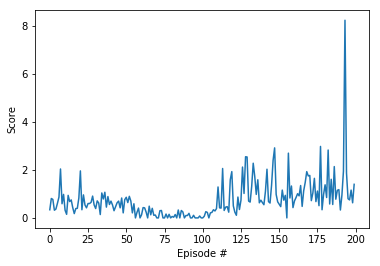

In [74]:
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Continue with a longer run overnight

In [ ]:
cont_scores = ddpg(agent, env, brain_name, max_episode=2000, previous_scores=scores)

Episode 300	Average Score: 1.33
Episode 400	Average Score: 1.05
Episode 456	Average Score: 0.64

When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 